In [1]:
import pandas as pd

In [2]:
df_factors = pd.read_csv('df_energy_factors.csv')
df_forecast = pd.read_csv('df_lstm_with_hdd_cdd_total_energy_forecast.csv')
df_forecast = df_forecast[df_forecast['predicted_total_energy'].notna()].reset_index(drop=True)

C:\Users\chen\AppData\Local\Temp\ipykernel_27004\2247691571.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_factors = pd.read_csv('df_energy_factors.csv')


In [4]:
df_factors.columns = df_factors.columns.str.lower()
df_forecast.columns = df_forecast.columns.str.lower()

In [5]:
df_factors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 854276 entries, 0 to 854275
Data columns (total 36 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   unnamed: 0                  854276 non-null  int64  
 1   energy_consumption_current  854276 non-null  int64  
 2   property_type               854276 non-null  object 
 3   built_form                  854276 non-null  object 
 4   construction_age_band       847570 non-null  object 
 5   total_floor_area            854276 non-null  float64
 6   floor_level                 692550 non-null  object 
 7   flat_top_storey             224305 non-null  object 
 8   floor_height                287314 non-null  float64
 9   extension_count             754448 non-null  float64
 10  number_habitable_rooms      754448 non-null  float64
 11  number_heated_rooms         754448 non-null  float64
 12  heat_loss_corridor          672648 non-null  object 
 13  glazed_type   

# Step1 electricity share, current and future

In [10]:
# 1. identify electricity fuel
electric_keywords = ['electric', 'electricity']
df_factors['is_electric'] = df_factors['main_fuel'].str.lower().apply(
    lambda x: any(keyword in x for keyword in electric_keywords)
)
# 2. electricity ratio, baseline
df_base_electric_share = (
    df_factors.groupby('local_authority')['is_electric']
    .mean()
    .reset_index()
    .rename(columns = {'is_electric': 'base_electricity_share'})
)
# 3. scenarios
years = list(range(2024, 2036))
scenarios = {
    'A': 0.70, # steady progress
    'B': 0.90, # policy driven
    'C': 0.60 # conservative
}

In [11]:
# interpolation for electricity share yearly
df_path = []

for _, row in df_base_electric_share.iterrows():
    loc = row['local_authority']
    base = row['base_electricity_share']
    for y in years:
        for s, target in scenarios.items():
            share = base + (target - base) * (y - 2023) / (2035 - 2023)
            df_path.append({
                'local_authority': loc,
                'year': y,
                f'electric_share_{s}': share
            })

# merge 3 scenarios
df_path = pd.DataFrame(df_path)
df_path = df_path.pivot_table(index=['local_authority', 'year'], aggfunc = 'first').reset_index()

df_path.head()

,local_authority,year,electric_share_A,electric_share_B,electric_share_C
0,E08000001,2024,0.160589,0.177255,0.152255
1,E08000001,2025,0.209626,0.242959,0.192959
2,E08000001,2026,0.258663,0.308663,0.233663
3,E08000001,2027,0.307701,0.374368,0.274368
4,E08000001,2028,0.356738,0.440072,0.315072


# Step2 Calculate increassed electricity demand

In [15]:
# merge forecast and df_path
df_merged = pd.merge(df_forecast, df_path, on = ['local_authority', 'year'], how = 'left')

# merge baseline share
df_merged = pd.merge(df_merged, df_base_electric_share, on = 'local_authority', how = 'left')
# new col, total current electricity demand
df_merged['electric_demand_current'] = (
    df_merged['predicted_total_energy'] * df_merged['base_electricity_share']
)

# increased demand = total energy yearly *(yearly share - baseline) / cop
COP = 3
for scenario in ['A', 'B', 'C']:
    df_merged[f'electric_demand_{scenario}'] = (
        df_merged['predicted_total_energy'] *
        (df_merged[f'electric_share_{scenario}'] - df_merged['base_electricity_share']) / COP
    ).clip(lower = 0) #　avoid negative values

# total demand = current demand + increased demand
for scenario in ['A', 'B', 'C']:
    df_merged[f'electric_total_{scenario}'] = (
        df_merged['electric_demand_current'] + df_merged[f'electric_demand_{scenario}']
    )
    
# output
df_result_sample = df_merged[['local_authority', 'year', 'predicted_total_energy', 'electric_demand_current',
                             'electric_share_A', 'electric_demand_A', 'electric_total_A',
                             'electric_share_B', 'electric_demand_B', 'electric_total_B',
                             'electric_share_C', 'electric_demand_C', 'electric_total_C']].head(5)
print(df_result_sample)

  local_authority  year  predicted_total_energy  electric_demand_current  \
0       E08000001  2024            1.402391e+08             1.564385e+07   
1       E08000001  2025            1.372487e+08             1.531027e+07   
2       E08000001  2026            1.367863e+08             1.525869e+07   
3       E08000001  2027            1.354872e+08             1.511377e+07   
4       E08000001  2028            1.321945e+08             1.474646e+07   

   electric_share_A  electric_demand_A  electric_total_A  electric_share_B  \
0          0.160589       2.292319e+06      1.793617e+07          0.177255   
1          0.209626       4.486878e+06      1.979714e+07          0.242959   
2          0.258663       6.707646e+06      2.196634e+07          0.308663   
3          0.307701       8.858586e+06      2.397236e+07          0.374368   
4          0.356738       1.080412e+07      2.555058e+07          0.440072   

   electric_demand_B  electric_total_B  electric_share_C  electric_demand_

In [17]:
# export main cols
output_columns = [
    'local_authority', 'year', 'predicted_total_energy',
    'base_electricity_share', 'electric_demand_current',
    'electric_share_A', 'electric_demand_A', 'electric_total_A',
    'electric_share_B', 'electric_demand_B', 'electric_total_B',
    'electric_share_C', 'electric_demand_C', 'electric_total_C'
]

df_export = df_merged[output_columns].reset_index(drop = True)
df_export.to_csv('electricity_demand_scenarios_with_hdd_cdd_2024_2035.csv', index = False)

# Step3 Result analysis

In [20]:
import matplotlib.pyplot as plt
import pandas as pd
df_export = pd.read_csv('electricity_demand_scenarios_with_hdd_cdd_2024_2035.csv')

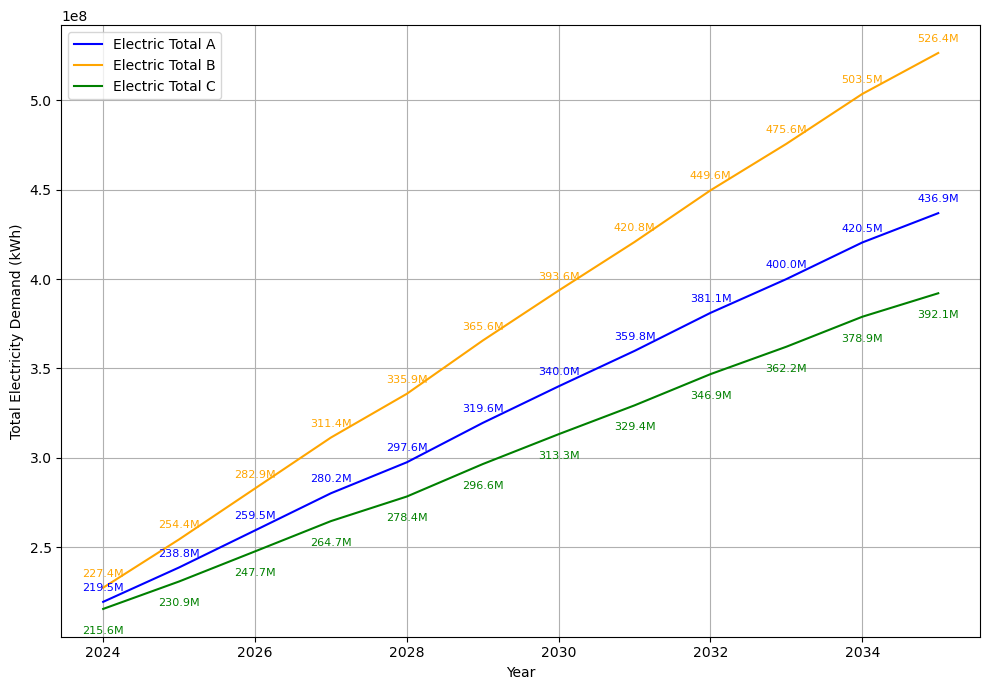

In [22]:
# yearly total demand
df_summary = df_export.groupby('year')[
    ['electric_total_A', 'electric_total_B', 'electric_total_C']
].sum().reset_index()

plt.figure(figsize=(10, 7))
# labels location
scenarios = [
    ('electric_total_A', 'blue', 5e6),
    ('electric_total_B', 'orange', 5e6),
    ('electric_total_C', 'green', -15e6)
]


for scenario, color, y_offset in scenarios:
    plt.plot(df_summary['year'], df_summary[scenario], 
             label=scenario.replace('_', ' ').title(), color=color)
    for x, y in zip(df_summary['year'], df_summary[scenario]):
        plt.text(x, y + y_offset, f'{y/1e6:.1f}M', fontsize=8, 
                 color=color, ha='center', va='bottom')

plt.xlabel('Year')
plt.ylabel('Total Electricity Demand (kWh)')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [24]:
# filter 2035 data
df_2035 = df_export[df_export['year'] == 2035].copy()

cols = [
    'local_authority',
    'electric_demand_A','electric_demand_B','electric_demand_C',
    'electric_total_A','electric_total_B','electric_total_C'
]

# extract and sort
df_report = df_2035[cols].sort_values('electric_total_B', ascending=False).reset_index(drop=True)

# export
df_report.to_csv('electric_demand_2035_by_district_with_hdd_cdd.csv', index=False)
print(df_report)

  local_authority  electric_demand_A  electric_demand_B  electric_demand_C  \
0       E08000003       3.780221e+07       5.454862e+07       2.942901e+07   
1       E08000006       2.118839e+07       3.102051e+07       1.627232e+07   
2       E08000007       2.659431e+07       3.562917e+07       2.207688e+07   
3       E08000001       2.593537e+07       3.475020e+07       2.152796e+07   
4       E08000010       2.713343e+07       3.578609e+07       2.280710e+07   
5       E08000004       2.721093e+07       3.558188e+07       2.302545e+07   
6       E08000002       2.272288e+07       3.014605e+07       1.901129e+07   
7       E08000008       2.365496e+07       3.121615e+07       1.987436e+07   
8       E08000005       2.353015e+07       3.093230e+07       1.982907e+07   
9       E08000009       1.603483e+07       2.176493e+07       1.316979e+07   

   electric_total_A  electric_total_B  electric_total_C  
0      1.002329e+08      1.169793e+08      9.185965e+07  
1      6.086056e+07      